20171103
Time evolution of matrix product mixed state

In [1]:
import numpy as np
from scipy import linalg
import scipy
%matplotlib notebook
import matplotlib.pyplot as plt
import time

Define basic functions

In [2]:
# returns Tr(o)
def mpotrace(o):
    L=len(o)
    temp=np.trace(o[0],axis1=0,axis2=1)
    for i in range(1,L):
        temp1=np.trace(o[i],axis1=0,axis2=1)
        temp=np.dot(temp,temp1)
    return temp[0,0]

# returns o*rho
def mpodot(o,rho):
    L=len(o)
    product=list()
    for i in range(0,L):
        temp=np.tensordot(o[i],rho[i],axes=([1,0])) # temp(os0,oa0,ob0,rhos0',rhoa0,rhob0)
        temp=np.transpose(temp,(0,3,1,4,2,5)) # temp(os0,rhos0',oa0,rhoa0,ob0,rhob0)
        sh=temp.shape
        temp=temp.reshape(sh[0],sh[1],sh[2]*sh[3],sh[4]*sh[5])
        product.append(temp)
    return product

# returns Tr(o*rho)
def exp(o,rho):
    return mpotrace(mpodot(o,rho))

def uni(rho):
    L=len(rho)
    temp=rho[0]
    for i in range(1,L):
        temp=np.tensordot(temp,rho[i],axes=([len(np.shape(temp))-1,2]))
    return np.squeeze(temp)

# returns trace of rho^\dag*rho
def norm(rho):
    L=len(rho)
    temp=np.tensordot(np.conj(rho[0]),rho[0],axes=([0,1],[0,1])) # temp(a0',b0',a0,b0) 'belongs to conj.
    temp=np.transpose(temp,(0,2,1,3)) # temp(a0',a0,b0',b0)
    for i in range(1,L):
        temp1=np.tensordot(np.conj(rho[i]),rho[i],axes=([0,1],[0,1])) # temp1(ai',bi',ai,bi)
        temp=np.tensordot(temp,temp1,axes=([2,3],[0,2])) # temp(a0',a0,bi',bi)
    return abs(temp[0,0,0,0])

# two-site evolution
def evo2(A1,A2,U,chi):
    theta=np.tensordot(A1,A2,axes=([3,2])) # theta(si,si',ai,s(i+1),s(i+1)',b(i+1))
    dai=A1.shape[2] # dimension of ai
    dbip1=A2.shape[3] # dimension of b(i+1)
    # apply U, theta(si,ai,s(i+1),b(i+1),si',s(i+1)')
    theta=np.tensordot(theta,U,axes=([1,4],[0,1])) 
    # apply U^\dag, theta(si,s(i+1),ai,b(i+1),si',s(i+1)')
    theta=np.tensordot(np.conj(np.transpose(U,(2,3,0,1))),theta,axes=([2,3],[0,2])) 
    theta=np.transpose(theta,(0,4,2,1,5,3)) # theta(si,si',ai,s(i+1),s(i+1)',b(i+1))
    sh=theta.shape
    theta=theta.reshape(sh[0]*sh[1]*sh[2],sh[3]*sh[4]*sh[5])
    #print(theta)
    [L,S,R]=scipy.linalg.svd(theta, lapack_driver='gesvd')
    ent=S.shape[0];
    for i in range(1,S.shape[0]):
        if S[i]<thr*S[0]:
            ent=i
            break
    if ent<chi:
        D=np.diag(np.sqrt(S[0:ent]))
    else:
        ent=chi
        D=np.diag(np.sqrt(S[0:ent]))
    L=L[:,0:ent]#/np.trace(np.dot(np.transpose(L.conj()),L)) # L(si*ai,bi)
    R=R[0:ent,:]#/np.trace(np.dot(np.transpose(R.conj()),R)) # R(a(i+1),s(i+1)*b(i+1))
    R=np.dot(D,R)
    L=np.dot(L,D)
    B1=L.reshape(d,d,dai,ent)
    B2=np.transpose(R.reshape(ent,d,d,dbip1),(1,2,0,3))
    return B1,B2

# single-site evolution
def evo1(A,U):
    # A(si,si',ai,bi)
    # U(si,si')
    A=np.tensordot(A,U,axes=([1,0])) # A(si,ai,bi,si')
    A=np.tensordot(np.conj(np.transpose(U)),A,axes=([1,0])) # A(si,ai,bi,si')
    A=np.transpose(A,(0,3,1,2)) # A(si,si',ai,bi)
    return A

# returns otoc=-Tr([W,V]^2)=-(Tr(WVWV)-Tr(WWVV))
def otoc(W,V):
    o1=mpodot(W,V)
    o1=mpodot(o1,o1)
    o2=mpodot(W,W)
    o2=mpodot(o2,V)
    o2=mpodot(o2,V)
    return -(mpotrace(o1)-mpotrace(o2))

# normalize the density matrix by setting rho*rho^\dag=1
def normalize(rho):
    L=len(rho)
    Norm=norm(rho)
    for i in range(0,L):
        rho[i]=rho[i]*(1/Norm)**(0.5/N)

# evolve the density matrix according to gates U_int and U_single for Nsteps times 
def evo(rho,U_int,U_single,Nsteps,chi):
    L=len(rho)
    for p in range(0,Nsteps):
        for i in range(0,L-1,2):
            temp1,temp2=evo2(rho[i],rho[i+1],U_int,chi)
            rho[i]=temp1
            rho[i+1]=temp2
        for i in range(1,L-1,2):
            temp1,temp2=evo2(rho[i],rho[i+1],U_int,chi)
            rho[i]=temp1
            rho[i+1]=temp2
        for i in range(0,L):
            rho[i]=evo1(rho[i],U_single)
        normalize(rho)

def hcee(rho):
    L=len(rho)
    LA=int(L/2)
    R=np.trace(rho[LA],axis1=0,axis2=1)
    for i in range(LA,int(L)):
        temp=np.trace(rho[i],axis1=0,axis2=1)
        R=np.dot(R,temp)
    rhoA=list(rho[0:LA])
    rhoA[LA-1]=np.tensordot(rhoA[LA-1],R,axes=([3,0]))
    ta=tuple(range(0,2*LA,2))
    tb=tuple(range(1,2*LA,2))
    temp1=uni(rhoA)
    temp2=np.transpose(temp1,ta+tb)
    MA=temp2.reshape(2**LA,2**LA)
    lam=np.linalg.eigvalsh(MA)
    ee=0
    for i in range(0,np.size(lam)):
        if lam[i]<1e-5:
            break
        ee=ee-lam[i]*np.log(lam[i])
    return ee


Define initial state, Hamiltonian and observables

In [17]:
sx=np.array([[0.,1.],[1.,0.]])
sy=np.array([[0.,-1j],[1j,0.]])
sz=np.array([[1.,0.],[0.,-1.]])

d=int(2) # Dimension. For spin 1/2 the dimention = 2
J=1. # interaction coefficient
gx=0. # X field strength
gy=0. # Y field strength
gz=0.2 # Z field strength
interaction='Ising' # Heisenberg: J(XX+YY+ZZ); Ising: JXX; Dipolar J(XX-(YY+ZZ)/2)
N=40 # Total number of spins
delta =0.02 # Time step
chi0=40 # Maximum number of singular values at t=0
Vc=10*J # upper bound of the growth velocity of correlation length. chi=max(chi0,Vc*t)
thr=1e-5; # discarding singular values smaller than thr*largest singular value
rho0i=sx # initial spin polarization

if interaction=='Heisenberg':
    h_int=J*np.kron(sx,sx)+J*np.kron(sy,sy)+J*np.kron(sz,sz)
elif interaction=='Ising':
    h_int=J*np.kron(sx,sx)
elif interaction=='Dipolar':
    h_int=J*(np.kron(sx,sx)-np.kron(sz,sz)/2-np.kron(sy,sy)/2)
else:
    raise NameError('Invalid interaction')

h_single=gz*sz+gx*sx+gy*sy
U_int=linalg.expm(1j*h_int*delta).reshape(d,d,d,d) # U(si,s(i+1),si',s(i+1)')
U_single=linalg.expm(1j*h_single*delta).reshape(d,d) # U(si,si')

Mz=list()
Mz.append(np.transpose(np.array([[sz,np.eye(2)]]),(2,3,0,1)))
for i in range(1,N-1):
    temp1=np.array([[np.eye(2),np.zeros((2,2))],[sz,np.eye(2)]])
    temp=np.transpose(temp1,(2,3,0,1))
    Mz.append(temp)
Mz.append(np.transpose(np.array([[np.eye(2)],[sz]]),(2,3,0,1))) # Mz(i,si,si',ai,bi)

Mx=list()
Mx.append(np.transpose(np.array([[sx,np.eye(2)]]),(2,3,0,1)))
for i in range(1,N-1):
    temp1=np.array([[np.eye(2),np.zeros((2,2))],[sx,np.eye(2)]])
    temp=np.transpose(temp1,(2,3,0,1))
    Mx.append(temp)
Mx.append(np.transpose(np.array([[np.eye(2)],[sx]]),(2,3,0,1))) # Mz(i,si,si',ai,bi)

V0=Mz # OTOC=-Tr[rhot,V0]^2

rho0=list()
rho0.append(np.transpose(np.array([[rho0i,np.eye(2)]]),(2,3,0,1)))
for i in range(1,N-1):
    temp1=np.array([[np.eye(2),np.zeros((2,2))],[rho0i,np.eye(2)]])
    temp=np.transpose(temp1,(2,3,0,1))
    rho0.append(temp)
rho0.append(np.transpose(np.array([[np.eye(2)],[rho0i]]),(2,3,0,1))) # rho(i,si,si',ai,bi)

# beta=0.001
# rho0i=linalg.expm(-beta*sz).reshape(d,d,1,1) # rho0i(si,si',ai,bi)
# rho0=list()
# for i in range(0,N):
#     rho0.append(rho0i)

Compute M(t)

In [18]:
start=time.time()
T=1 # evolution time to be simulated
Nsteps=5 # number of evolution steps between two measurements
Npts=int(T/delta/Nsteps+1) # number of points to evalue the observables
tlist=np.arange(0,Npts*delta*Nsteps,delta*Nsteps)

MzExp=np.zeros(Npts)
MxExp=np.zeros(Npts)

# rho=list(Mx)
rho=list(rho0)
normalize(rho)
MzExp[0]=np.real(exp(Mz,rho))
MxExp[0]=np.real(exp(Mx,rho))

for p in range(1,Npts):
    chi=int(chi0+tlist[p]*Vc)
    evo(rho,U_int,U_single,Nsteps,chi)
    MzExp[p]=np.real(exp(Mz,rho))
    MxExp[p]=np.real(exp(Mx,rho))
    print(tlist[p])
end=time.time()
print(end-start)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.508896827697754


In [19]:
plt.plot(tlist,MxExp/MxExp[0])
plt.show()

<IPython.core.display.Javascript object>


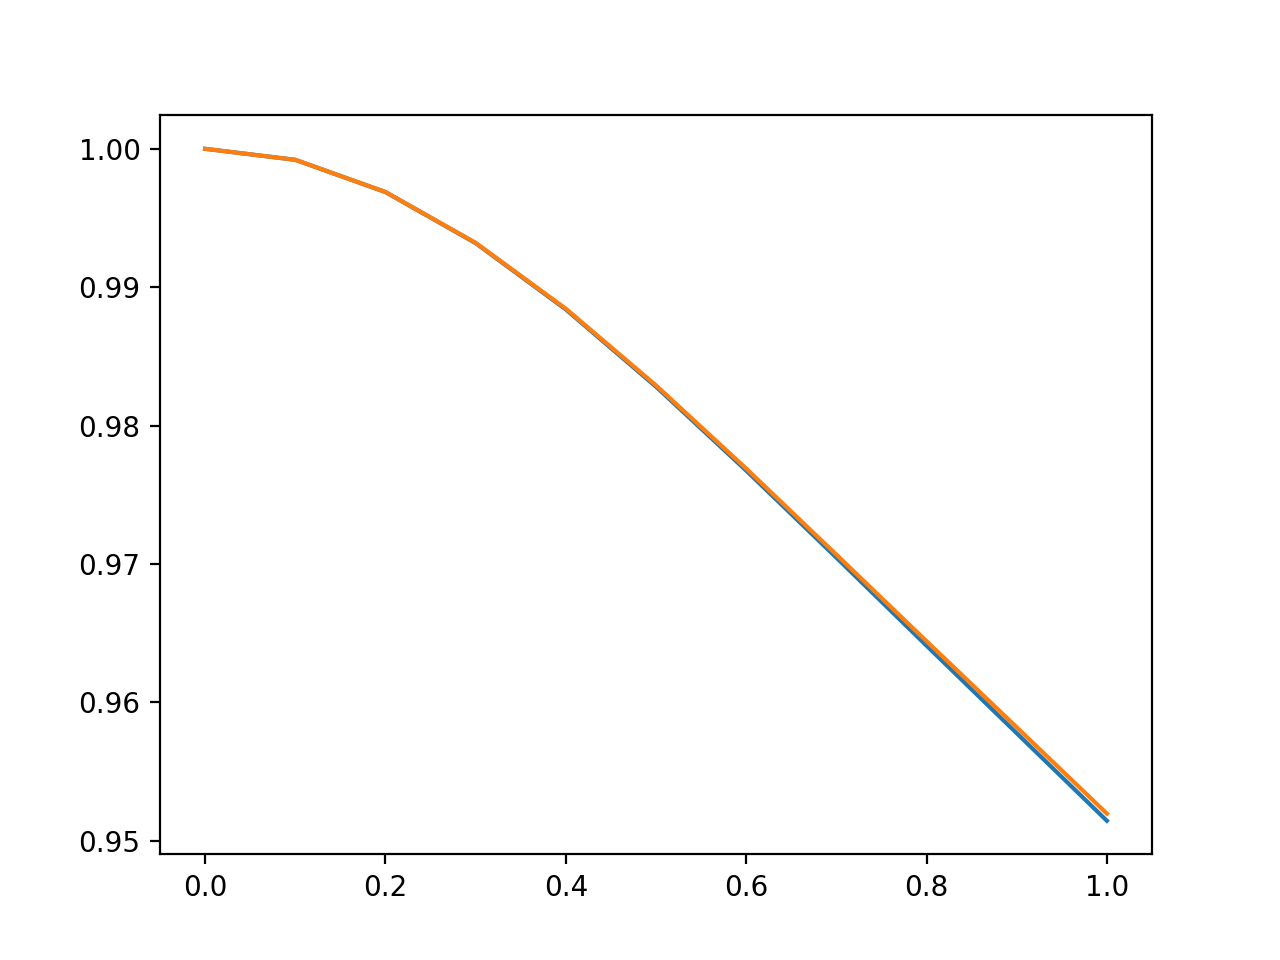

In [15]:
plt.plot(tlist,MxExp/MxExp[0])
plt.show()

In [20]:
MxExp

array([ 6631776.91957744,  6626505.1451366 ,  6611101.4571309 ,
        6586735.78903235,  6555153.64484105,  6518407.55919794,
        6478540.85846163,  6437284.26883737,  6395800.93740035,
        6354527.03892712,  6313146.15612778])

In [17]:
Tcon=10
Npts0=Npts
Npts=int(Tcon/delta/Nsteps) # number of points to evalue the observables
tlist=np.append(tlist,np.arange(tlist[-1]+delta*Nsteps,tlist[-1]+Npts*delta*Nsteps,delta*Nsteps))

for p in range(Npts0,Npts0+Npts-1):
    chi=int(chi0+tlist[p]*Vc)
    evo(rho,U_int,U_single,Nsteps,chi)
    MzExp=np.append(MzExp,np.real(exp(Mz,rho)))
    MxExp=np.append(MxExp,np.real(exp(Mx,rho)))

Compute OTOC using the trace of 4 operators, which is not efficient.

In [20]:
Npts=int(T/delta/Nsteps+1) # number of points to evalue the observables
tlist=np.arange(0,Npts*delta*Nsteps,delta*Nsteps)
gzlist=np.arange(0.9,1.2,0.1)
OTOC=np.zeros((len(tlist),len(gzlist)))

for pp in range(0,len(gzlist)):
    gz=gzlist[pp]
    print(gz)
    h_single=gz*sz
    U_single=linalg.expm(1j*h_single*delta).reshape(d,d) # U(si,si')
    rho=list(rho0)
    normalize(rho)
    OTOC[0,pp]=np.real(otoc(rho,V0))
    for p in range(1,Npts):
        evo(rho,U_int,U_single,Nsteps,chi)
        OTOC[p,pp]=np.real(otoc(rho,V0))

0.9
1.0
1.1


In [59]:
start=time.time()
T=0.5
Npts=round(T/delta) # number of points to evalue the observables
q_max=3
phi_list=np.arange(0,2*q_max,1)*2*np.pi/(2*q_max)
s_list=[]

rho=list(Mz)
V0=sz # encoding axis
normalize(rho)
evo(rho,U_int,U_single,Npts,chi0)
for phi in phi_list:
    U_phi=linalg.expm(1j*phi/2*V0)
    rhot=list(rho)
    evo(rhot,np.eye(d**2).reshape(d,d,d,d),U_phi,1,chi0)
    evo(rhot,np.conj(U_int),np.conj(U_single),Npts,chi0)
    s_list=np.append(s_list,np.real(exp(rhot,Mz)))
    print(phi)
end=time.time()
print(end-start)

0.0
1.0471975512
2.09439510239
3.14159265359
4.18879020479
5.23598775598
7.1339709758758545


In [60]:
s_list

array([ 45.25456001,   1.34983363,   1.57077201,  45.25456001,
         1.34983363,   1.57077201])

In [31]:
np.sqrt(2048)

45.254833995939045

<IPython.core.display.Javascript object>


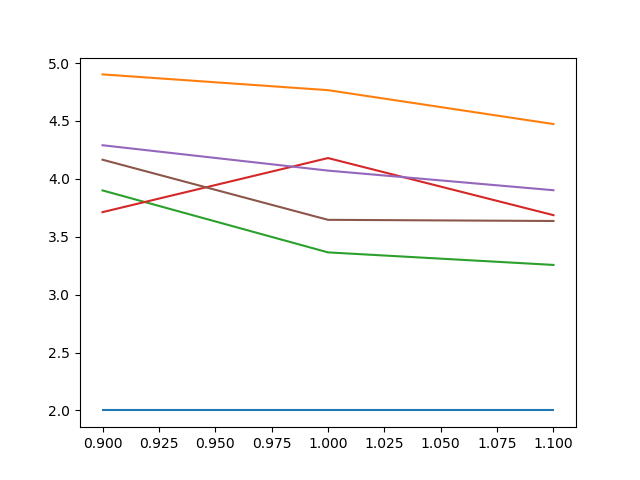

In [127]:
# plt.close()
plt.figure(1)
for p in range(0,len(tlist)):
    plt.plot(gzlist,OTOC[p,:])
plt.show()

<IPython.core.display.Javascript object>


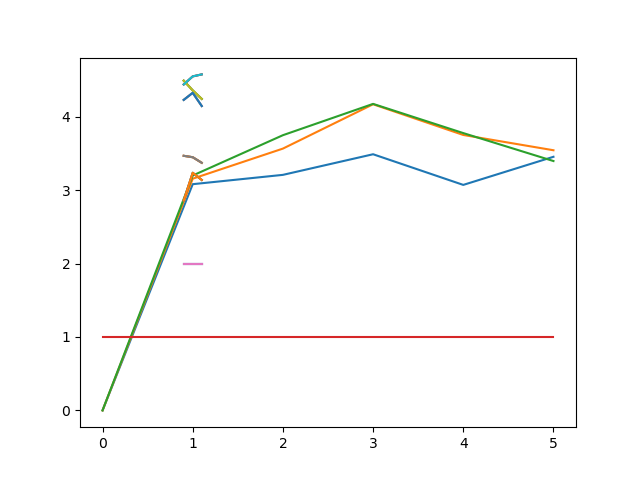

In [37]:
for p in range(0,len(gzlist)):
    plt.plot(tlist,OTOC[:,p])
plt.show()

In [61]:
tlist=np.arange(0,20.2,delta*Nsteps)

In [52]:
Npts*delta*Nsteps

20.200000000000003

In [55]:
Npts

101